In [2]:
!pip install pandas yfinance numpy matplotlib scikit-learn seaborn tensorflow torch

  Using cached typing_extensions-4.15.0-py3-none-any.whl.metadata (3.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 MB 9.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 10.1 MB/s eta 0:00:0000:0100:01
Using cached typing_extensions-4.15.0-py3-none-any.whl (44 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 7.1 MB/s eta 0:00:00ta 0:00:01
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.9.0
    Uninstalling typing_extensions-4.9.0:
      Successfully uninstalled typing_extensions-4.9.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastkml 1.1.0 requires arrow, which is not installed.


1. XGBOOST İÇİN VERİ HAZIRLANIYOR...


/var/folders/xl/_cnln_n95bq4hsnmlbfd4_vw0000gn/T/ipykernel_54348/1959096774.py:27: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('BTC-USD', start=start_date, end=end_date, progress=False, threads=False)



2. XGBOOST OPTİMİZASYONU VE EĞİTİMİ...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
✓ En İyi Parametreler: {'subsample': 0.9, 'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
   • Learning Curve verisi toplanıyor...
   • Metrikler kaydedildi.

5. GRAFİKLER OLUŞTURULUYOR...

✓ XGBOOST MODELİ TAMAMLANDI.


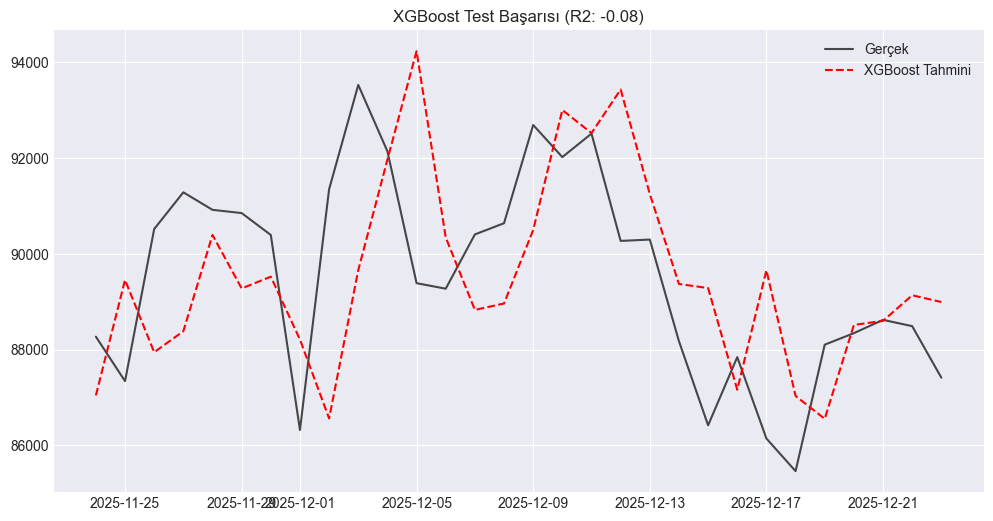

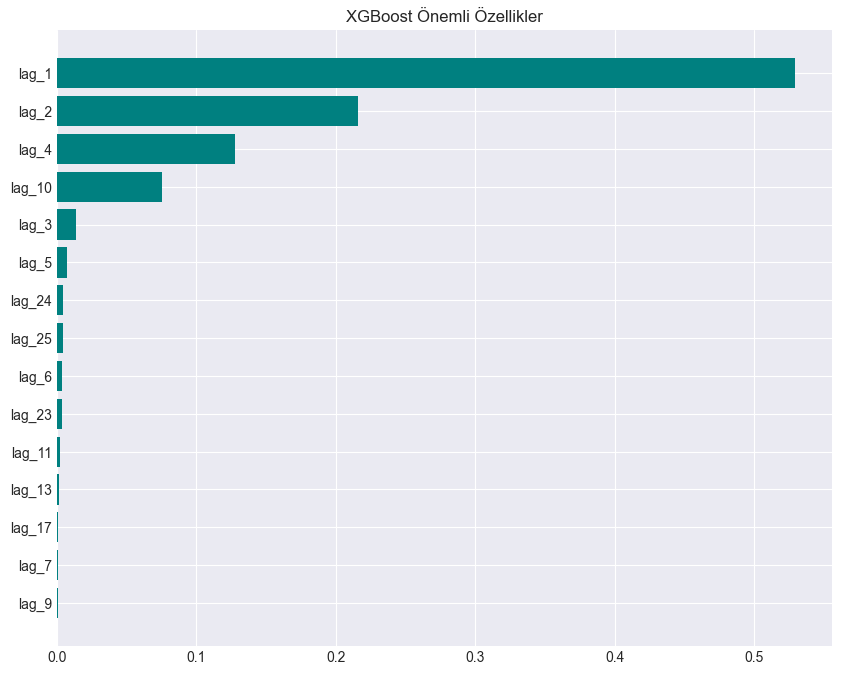

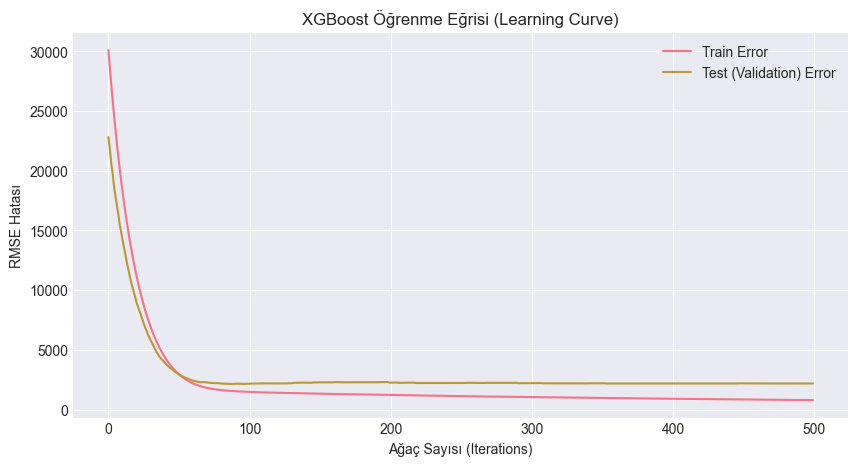

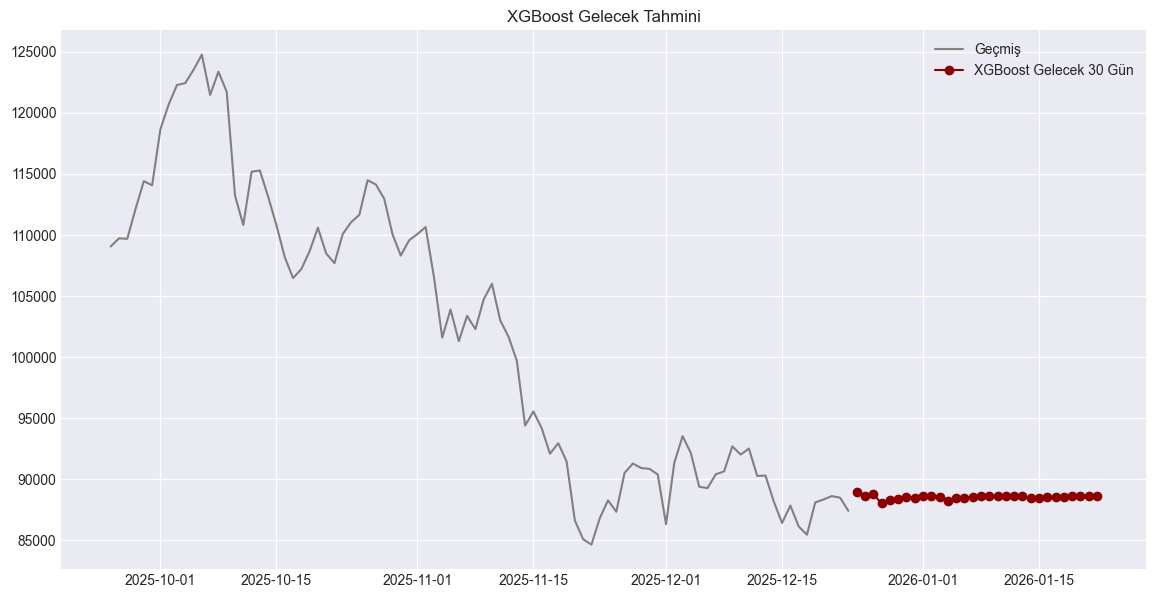

In [1]:
# =============================================================================
# MODEL 1: XGBOOST REGRESSOR (Final Revize - Learning Curve Ekli)
# =============================================================================

import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import xgboost as xgb
from datetime import date, timedelta
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

# Görselleştirme Ayarları
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# 1. VERİ HAZIRLAMA
print("1. XGBOOST İÇİN VERİ HAZIRLANIYOR...")
today = date.today()
end_date = today.strftime("%Y-%m-%d")
start_date = (today - timedelta(days=1095)).strftime("%Y-%m-%d") # 3 Yıl

try:
    df = yf.download('BTC-USD', start=start_date, end=end_date, progress=False, threads=False)
    if isinstance(df.columns, pd.MultiIndex): df.columns = df.columns.get_level_values(0)
    df.reset_index(inplace=True)
except:
    df = pd.DataFrame()

data = df[['Date', 'Close']].copy()

# Feature Engineering
n_lags = 30
for i in range(1, n_lags + 1):
    data[f'lag_{i}'] = data['Close'].shift(i)

data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)
last_known_row = data.iloc[-1]

test_days = 30
train_data = data.iloc[:-test_days]
test_data = data.iloc[-test_days:]

feature_cols = [f'lag_{i}' for i in range(1, n_lags + 1)]
X_train = train_data[feature_cols]
y_train = train_data['Close']
X_test = test_data[feature_cols]
y_test = test_data['Close']

# 2. TUNING VE EĞİTİM (LEARNING CURVE İÇİN ÖZEL EĞİTİM)
print("\n2. XGBOOST OPTİMİZASYONU VE EĞİTİMİ...")

xgb_params = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

tscv = TimeSeriesSplit(n_splits=5)
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

search = RandomizedSearchCV(
    estimator=model,
    param_distributions=xgb_params,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=tscv,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

search.fit(X_train, y_train)
best_params = search.best_params_
print(f"✓ En İyi Parametreler: {best_params}")

# FİNAL EĞİTİMİ (Learning Curve yakalamak için tekrar eğitiyoruz)
print("   • Learning Curve verisi toplanıyor...")
final_model = xgb.XGBRegressor(**best_params, objective='reg:squarederror', random_state=42)

# eval_set parametresini kullanarak her adımda hatayı takip ediyoruz
final_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)

joblib.dump(final_model, 'xgb_model_final.pkl')

# 3. METRİKLER
y_pred = final_model.predict(X_test)
metrics = {
    "R2": r2_score(y_test, y_pred),
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
    "MAE": mean_absolute_error(y_test, y_pred),
    "MAPE": mean_absolute_percentage_error(y_test, y_pred)
}
pd.DataFrame([metrics]).to_csv("xgb_metrics.csv", index=False)
print("   • Metrikler kaydedildi.")

# 4. GELECEK TAHMİNİ
future_preds = []
current_features = last_known_row[feature_cols].values.reshape(1, -1)

for i in range(30):
    pred = final_model.predict(current_features)[0]
    future_preds.append(pred)
    new_features = np.roll(current_features, 1)
    new_features[0, 0] = pred
    current_features = new_features

last_date = data['Date'].max()
future_dates = [last_date + timedelta(days=x) for x in range(1, 31)]
forecast_df = pd.DataFrame({'Date': future_dates, 'Forecast': future_preds})
forecast_df.to_csv('xgb_future_forecast.csv', index=False)

# 5. GÖRSELLEŞTİRME
print("\n5. GRAFİKLER OLUŞTURULUYOR...")

# Grafik 1: Test Prediction
plt.figure(figsize=(12, 6))
plt.plot(test_data['Date'], y_test, label='Gerçek', color='black', alpha=0.7)
plt.plot(test_data['Date'], y_pred, label='XGBoost Tahmini', color='red', linestyle='--')
plt.title(f'XGBoost Test Başarısı (R2: {metrics["R2"]:.2f})')
plt.legend()
plt.savefig('xgb_1_test_prediction.png')

# Grafik 2: Feature Importance
plt.figure(figsize=(10, 8))
importance = final_model.feature_importances_
indices = np.argsort(importance)[-15:]
plt.barh(range(len(indices)), importance[indices], align='center', color='teal')
plt.yticks(range(len(indices)), [feature_cols[i] for i in indices])
plt.title('XGBoost Önemli Özellikler')
plt.savefig('xgb_2_feature_importance.png')

# Grafik 3: LEARNING CURVE (YENİ EKLENDİ)
results = final_model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
plt.figure(figsize=(10, 5))
plt.plot(x_axis, results['validation_0']['rmse'], label='Train Error')
plt.plot(x_axis, results['validation_1']['rmse'], label='Test (Validation) Error')
plt.title('XGBoost Öğrenme Eğrisi (Learning Curve)')
plt.xlabel('Ağaç Sayısı (Iterations)')
plt.ylabel('RMSE Hatası')
plt.legend()
plt.savefig('xgb_3_learning_curve.png')

# Grafik 4: Future Forecast
plt.figure(figsize=(14, 7))
hist_df = data.iloc[-90:]
plt.plot(hist_df['Date'], hist_df['Close'], label='Geçmiş', color='gray')
plt.plot(forecast_df['Date'], forecast_df['Forecast'], label='XGBoost Gelecek 30 Gün', color='darkred', marker='o')
plt.title('XGBoost Gelecek Tahmini')
plt.legend()
plt.savefig('xgb_4_future_forecast.png')

print("\n✓ XGBOOST MODELİ TAMAMLANDI.")